In [60]:
'''
Please install pandas_datareader for use. 
'''

# Import packages
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr

start = dt.datetime(2019,1,1)
end = 'now'

#CKH = pdr.DataReader('0001.HK','yahoo',start, end)
#TCEHY = pdr.DataReader('0700.HK','yahoo',start, end)
#HKEX = pdr.DataReader('0388.HK','yahoo',start, end)
USDJPY = pdr.DataReader('USDJPY=X','yahoo',start, end)
#GBPJPY = pdr.DataReader('GBPJPY=X','yahoo',start, end)

# Define the SMA parameters
SMA1 = 5
SMA2 = 15

# Calculate the SMA values
USDJPY['SMA1'] = USDJPY['Close'].rolling(SMA1).mean()
USDJPY['SMA2'] = USDJPY['Close'].rolling(SMA2).mean()

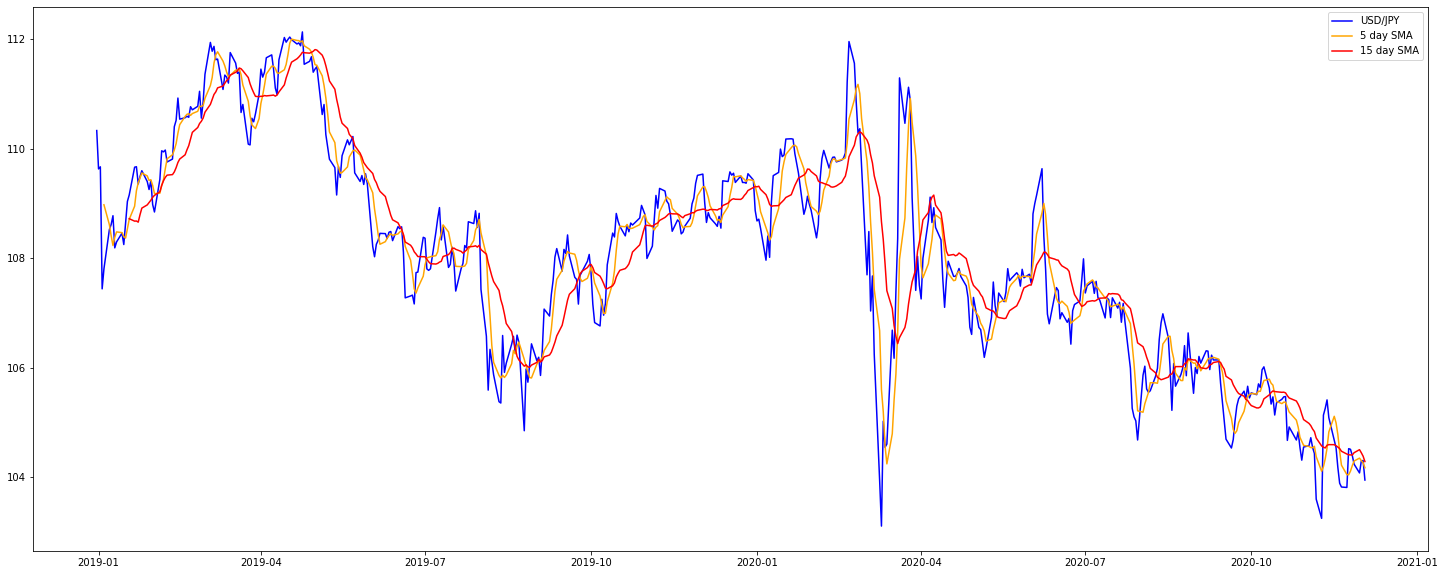

In [61]:
# Plot close, SMA1 and SMA2
plt.figure(figsize=(25,10))
plt.plot(USDJPY['Close'], label = 'USD/JPY', color = 'blue')
plt.plot(USDJPY['SMA1'], label = '5 day SMA', color = 'orange')
plt.plot(USDJPY['SMA2'], label = '15 day SMA', color = 'red')
plt.legend(loc='upper right')
plt.show()